In [1]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define paths to your dataset
dataset_path = 'D:/DATASET/CNN/ballooning/train'

# Define the subdirectories for each class
class_names = ['0', '1']

# Initialize lists to store images and labels
images = []
labels = []

In [2]:
# Loop through each class directory
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    
    # Loop through each image in the class directory
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        
        # Read and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error: Unable to load image at path: {image_path}")
            continue  # Skip to the next image
        if image.size == 0:
            print(f"Error: Empty image at path: {image_path}")
            continue  # Skip to the next image
        image = cv2.resize(image, (224, 224))
        image = np.expand_dims(image, axis=-1)  # Add channel dimension
        images.append(image)
        
        # Assign the label based on the class directory
        label = int(class_name)
        labels.append(label)

Error: Unable to load image at path: D:/DATASET/CNN/ballooning/train\0\Thumbs.db
Error: Unable to load image at path: D:/DATASET/CNN/ballooning/train\1\Thumbs.db


In [3]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print the shapes of the images and labels arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (27698, 224, 224, 1)
Labels shape: (27698,)


In [5]:
# X: images, y: labels
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255
)

In [11]:
# Calculate class weights manually
unique_classes = np.unique(y_train)
class_counts = np.bincount(y_train)
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(unique_classes) * class_counts)

# Convert class weights to dictionary
class_weight_dict = dict(zip(unique_classes, class_weights))

In [16]:
image_height= 224
image_width= 224

In [17]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32), epochs=5, 
                    validation_data=(X_test, y_test), class_weight=class_weight_dict)

Epoch 1/5
693/693 [==============================] - 745s 1s/step - loss: 0.5842 - accuracy: 0.7127 - val_loss: 15.8466 - val_accuracy: 0.9276
Epoch 2/5
693/693 [==============================] - 866s 1s/step - loss: 0.5225 - accuracy: 0.7526 - val_loss: 10.8782 - val_accuracy: 0.9565
Epoch 3/5
693/693 [==============================] - 854s 1s/step - loss: 0.4814 - accuracy: 0.7929 - val_loss: 15.1962 - val_accuracy: 0.9691
Epoch 4/5
693/693 [==============================] - 848s 1s/step - loss: 0.4613 - accuracy: 0.8109 - val_loss: 26.6185 - val_accuracy: 0.9708
Epoch 5/5
693/693 [==============================] - 896s 1s/step - loss: 0.4490 - accuracy: 0.8165 - val_loss: 16.0519 - val_accuracy: 0.9648


In [19]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

174/174 [==============================] - 51s 296ms/step - loss: 16.0519 - accuracy: 0.9648
Test Accuracy: 0.9648014307022095


In [20]:
# Save the model
model.save('D:/DATASET/Models/model_ballooning')

INFO:tensorflow:Assets written to: D:/DATASET/Models/model_ballooning\assets


INFO:tensorflow:Assets written to: D:/DATASET/Models/model_ballooning\assets


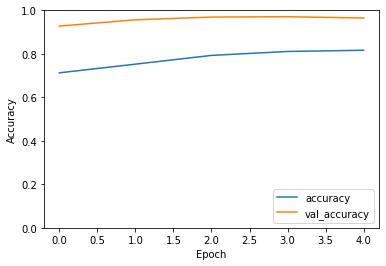

In [23]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [25]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def predict_image(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0) / 255.0

    # Predict the score
    prediction = model.predict(image)
    score = np.argmax(prediction)
    
    print("Predictions: ",prediction)
    
    # Define the NASH score mapping
    nash_scores = {
        0: "0: Ballooning absent",
        1: "1: Ballooning present"
    }
    
    # Get the NASH score corresponding to the maximum probability
    nash_score = nash_scores[score]
    
    # Print the NASH score
    print('Predicted NASH score:', nash_score)

# Load the model
#model = load_model('D:/DATASET/Models/model_ballooning.h5')

In [26]:
# Plot evaluation graphs for the input image
def plot_evaluation(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0) / 255.0

    # Predict the score
    prediction = model.predict(image)
    predicted_score = np.argmax(prediction)

    # Plot sample predictions
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Predicted Score: {predicted_score}")
    plt.axis('off')
    plt.show()

    # Confusion matrix
    y_true = [0]  # As we are plotting for only one image
    predicted_classes = [predicted_score]
    conf_matrix = confusion_matrix(y_true, predicted_classes)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, predicted_classes)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

1/1 [==============================] - 0s 42ms/step
Predictions:  [[0.81551844]]
Predicted NASH score: 0: Ballooning absent
1/1 [==============================] - 0s 55ms/step


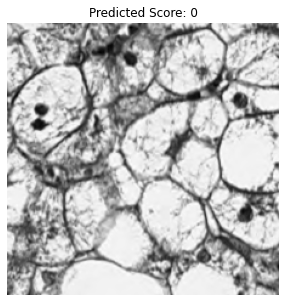

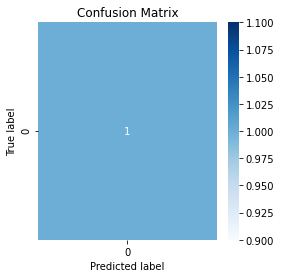

C:\Users\JUHI\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


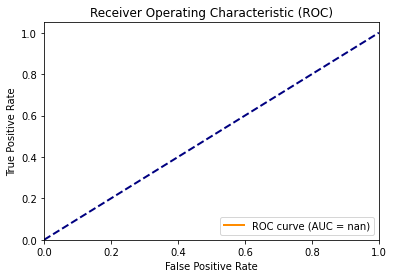

In [30]:
# Take input image path from the user
image_path = "D:/DATASET/CNN/ballooning/train/1/8_273_31.png"

predict_image(image_path, model)
# Plot evaluation graphs for the input image
plot_evaluation(image_path, model)